In [1]:
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import xarray as xr
import pandas as pd
from scipy import special, stats
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
#сделать те же модели  для синих цветков sepal length, сначала на базе sepal length (аналог массы пингвина),
#потом добавить другие переменные  (должно получится 4 модели)

In [2]:
from sklearn import datasets

iris = datasets.load_iris()

In [120]:
from scipy.stats import pearsonr

X = iris_dataset[['sepal length (cm)']].values
y = iris_dataset['sepal width (cm)'].values

# Посчитаем корреляцию
correlation, _ = pearsonr(X.flatten(), y)
print(f'Корреляция: {correlation}')

Корреляция: -0.11756978413300206


In [4]:
iris_dataset=pd.DataFrame(iris['data'],columns=iris['feature_names'])

In [5]:
iris_dataset['species']=iris['target']

In [7]:
iris_dataset.pivot_table(index='species', values='sepal length (cm)', aggfunc = ["mean", "std", "count"])

,mean,std,count
,sepal length (cm),sepal length (cm),sepal length (cm)
species,,,
0,5.006,0.352490,50
1,5.936,0.516171,50
2,6.588,0.635880,50


In [8]:
iris_dataset.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [10]:
setosa_mask = iris_dataset["species"] == 0
setosa_sepal_length_obs = iris_dataset.loc[setosa_mask, "sepal length (cm)"].values

with pm.Model() as model_setosa_sepal_length:
    σ = pm.HalfNormal("σ", 10)
    μ = pm.Normal("μ",5,  10)
    mass = pm.Normal("sepal length", mu=μ, sigma=σ, observed=setosa_sepal_length_obs)
    idata_sepal_length = pm.sample(chains=4)
    idata_sepal_length.extend(pm.sample_prior_predictive(samples=5000))

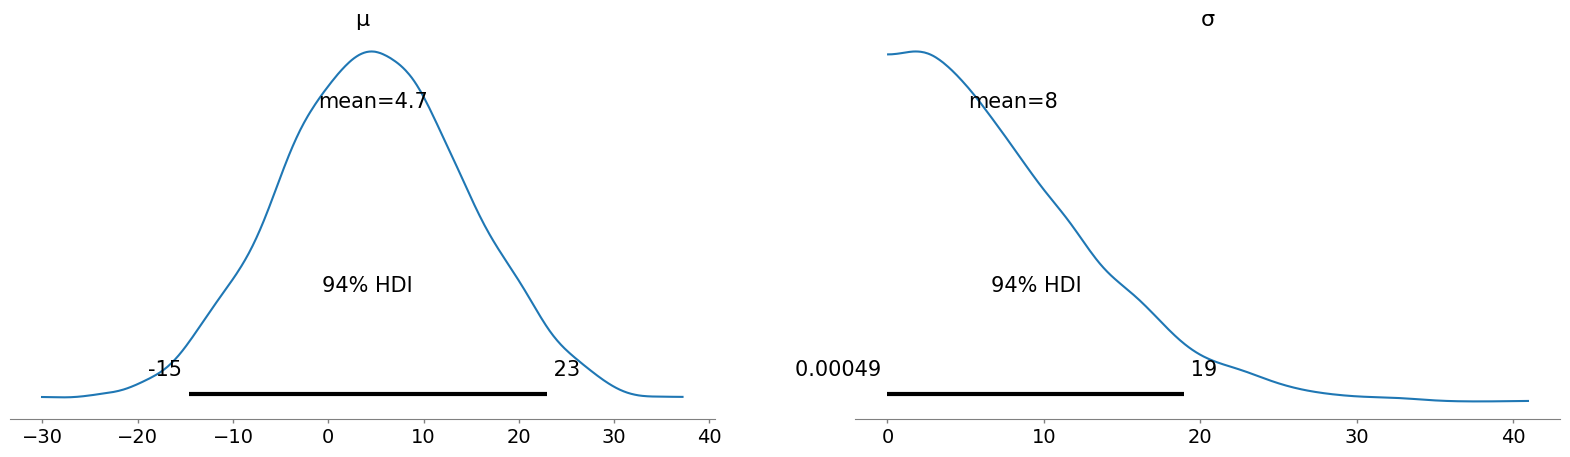

In [11]:
axes = az.plot_posterior(idata_sepal_length.prior, var_names=["μ", "σ"], figsize=(20, 5))

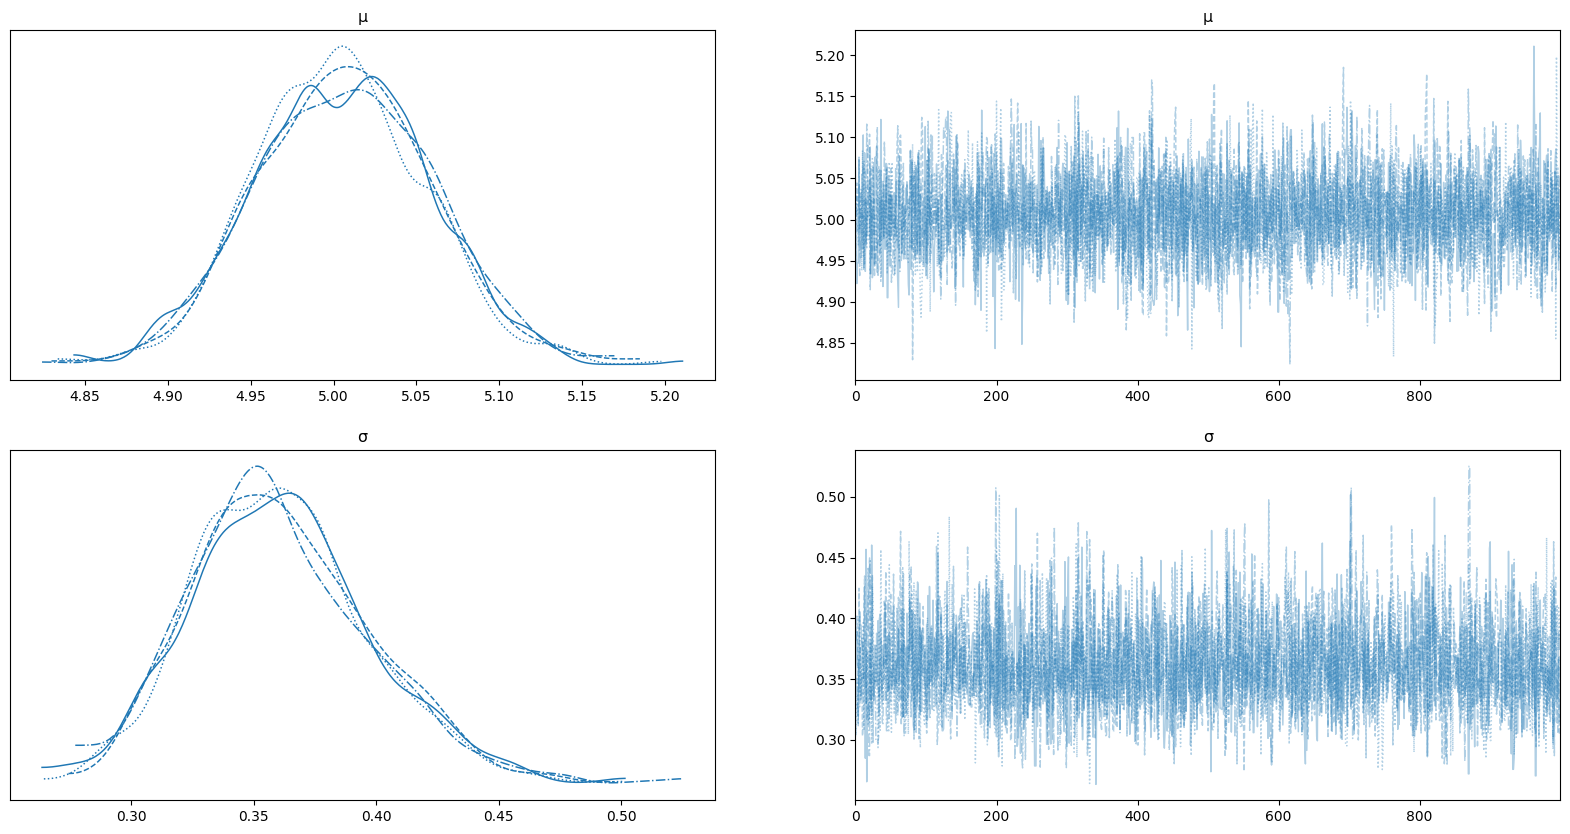

In [12]:
axes = az.plot_trace(idata_sepal_length, figsize=(20, 10))
#видно, что апостериорные распределения для 4 цепей очень похожи, значит все сошлось

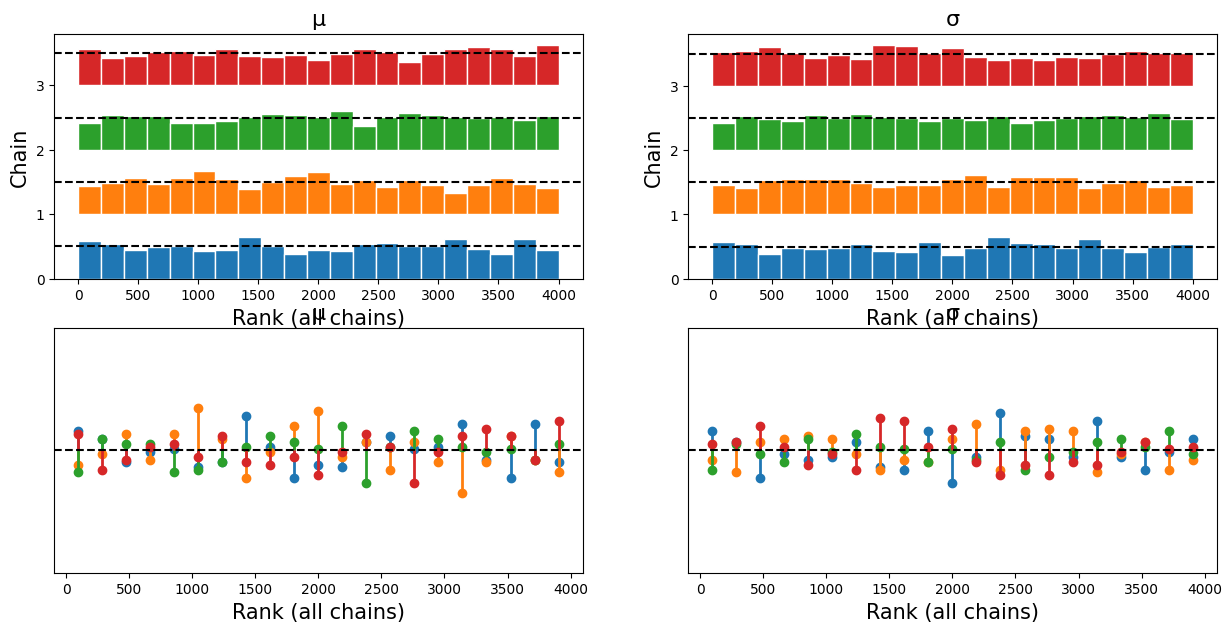

In [13]:
fig, (ax1,ax2) = plt.subplots(2,2, figsize=(15,7))
az.plot_rank(idata_sepal_length, kind="bars", ax=ax1);
az.plot_rank(idata_sepal_length, kind="vlines", ax=ax2);
#ранговые графики выглядят примерно одинаково, что опять же подтверждает сходимость цепей

In [ ]:
az.summary(idata_sepal_length)
#здесь тоже все хорошо, ess_bulk близко к размеру нашей выборки, mcse очень мал

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,5.006,0.051,4.915,5.105,0.001,0.001,3899.0,2646.0,1.0
σ,0.363,0.037,0.298,0.436,0.001,0.000,3519.0,2766.0,1.0


## линейная регрессия с шириной чашелистника

In [147]:
setosa_sepal_width_obs = iris_dataset.loc[setosa_mask, "sepal width (cm)"]

with pm.Model() as model_sepal_width_regression:
    sepal_width = pm.Data("sepal_width",
                                     setosa_sepal_width_obs)
    σ = pm.HalfNormal("σ", 10)
    β_0 = pm.Normal("β_0", 0, 10)
    β_1 = pm.Normal("β_1", 0, 10)
    μ = pm.Deterministic("μ", β_0 + β_1 * sepal_width)

    sepal_length = pm.Normal("sepal length", mu=μ, sigma=σ, observed=setosa_sepal_length_obs)

    idata_sepal_width_regression = pm.sample(chains=4)

In [148]:
az.summary(idata_sepal_width_regression,
           var_names=["β_0","β_1", "σ"])
#все норм

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β_0,2.631,0.330,2.049,3.254,0.010,0.007,1179.0,1115.0,1.0
β_1,0.693,0.096,0.518,0.871,0.003,0.002,1185.0,1165.0,1.0
σ,0.245,0.026,0.199,0.295,0.001,0.000,1859.0,1764.0,1.0


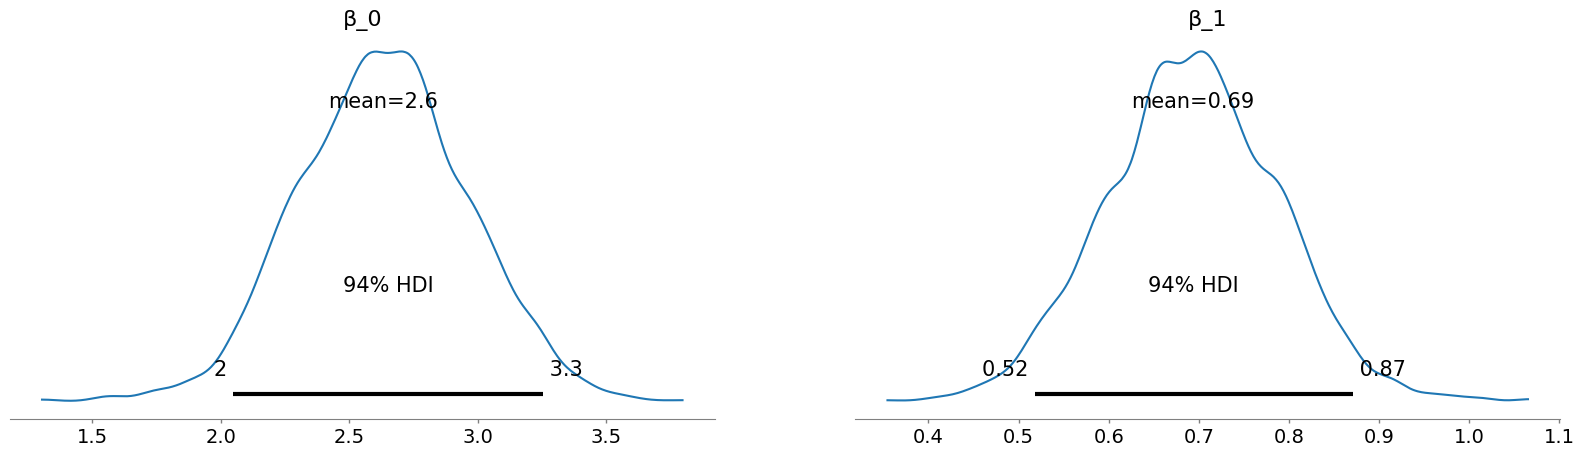

In [149]:
axes = az.plot_posterior(idata_sepal_width_regression, var_names = ["β_0", "β_1"], figsize=(20, 5));
#0 не входит в интервал наибольшей плотности в 94%, что хорошо

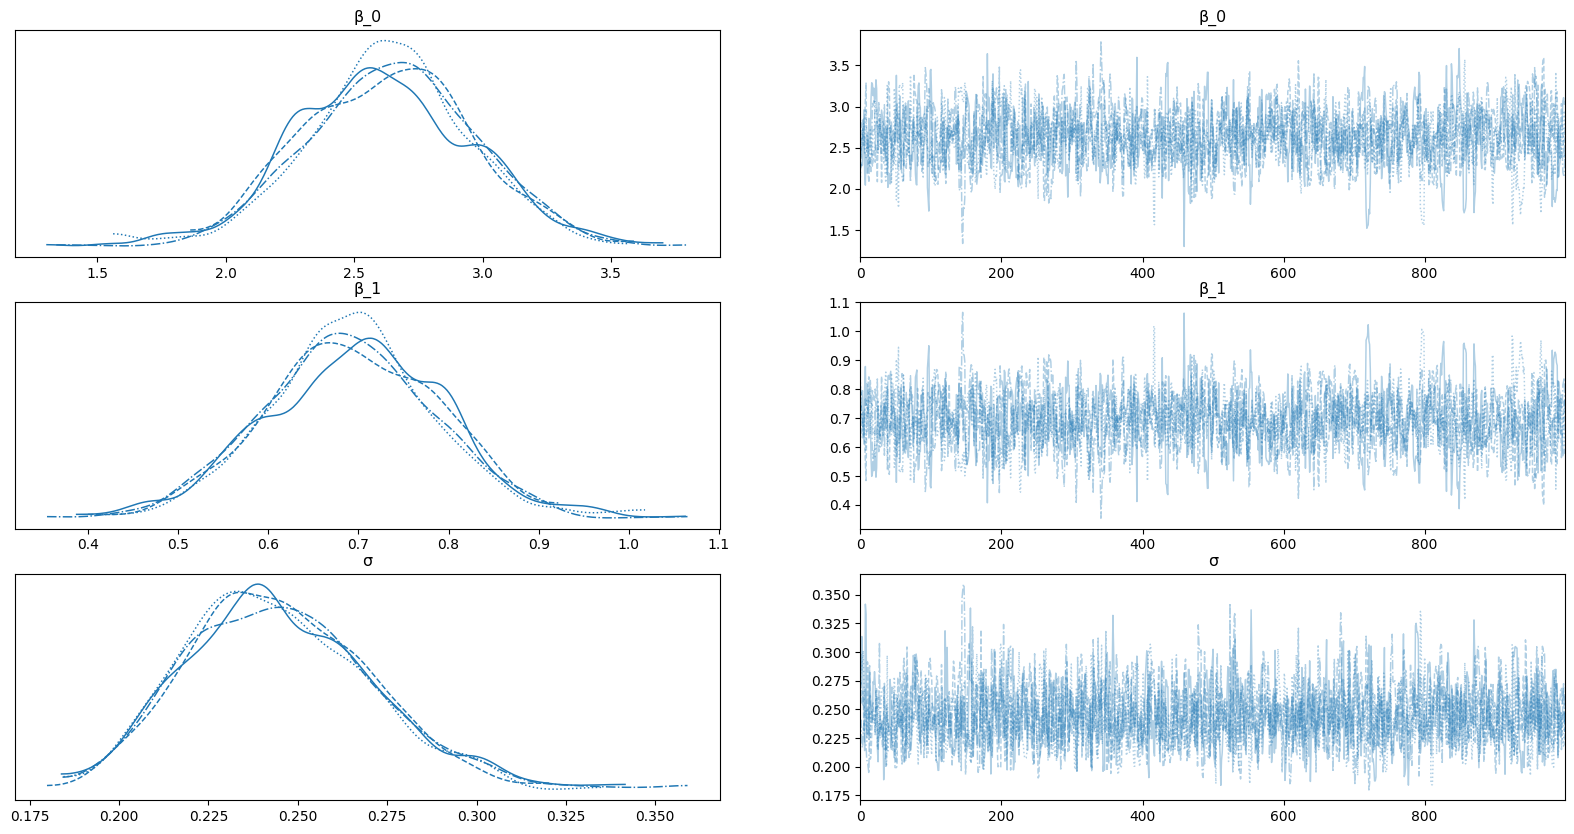

In [150]:
axes = az.plot_trace(idata_sepal_width_regression,var_names=["β_0","β_1", "σ"], figsize=(20, 10))
#сходимость есть

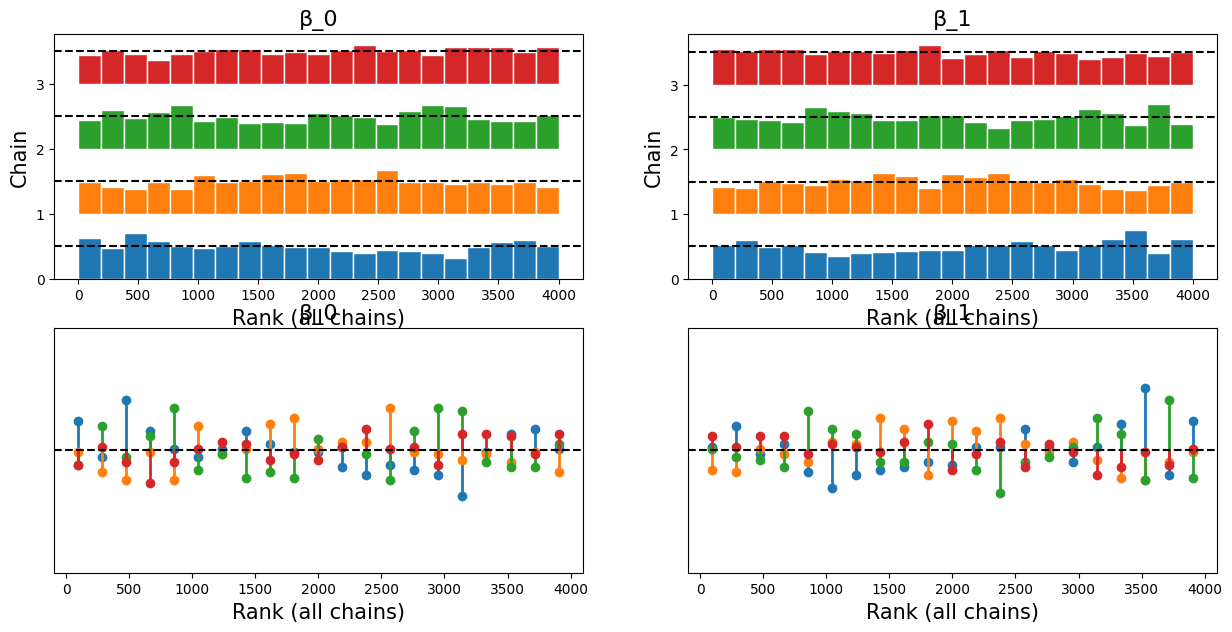

In [151]:
fig, (ax1,ax2) = plt.subplots(2,2, figsize=(15,7))
az.plot_rank(idata_sepal_width_regression, kind="bars", ax=ax1);
az.plot_rank(idata_sepal_width_regression, kind="vlines", ax=ax2);

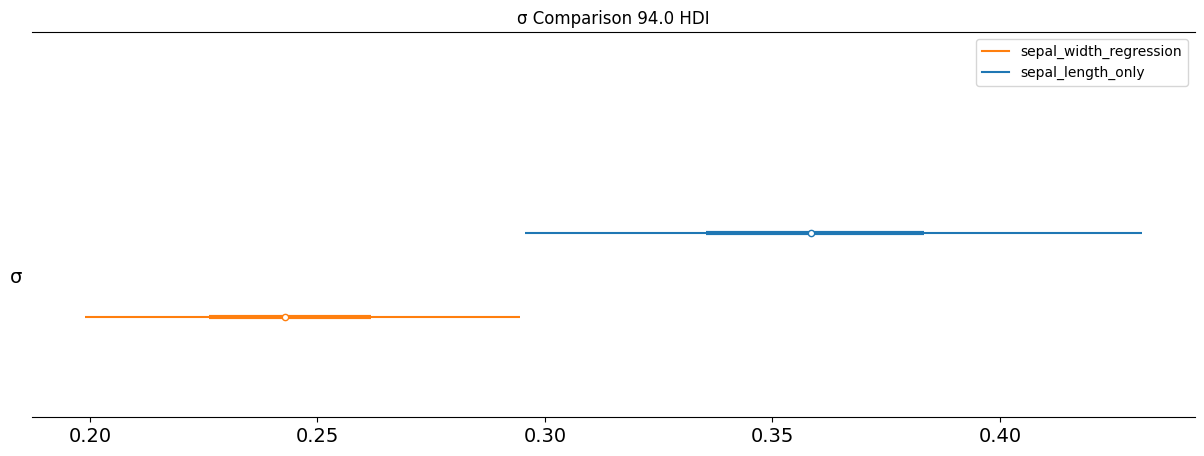

In [152]:
axes = az.plot_forest(
    [idata_sepal_length, idata_sepal_width_regression],
    model_names=["sepal_length_only", "sepal_width_regression"],
    var_names=["σ"], combined=True, figsize=(15, 5))
axes[0].set_title("σ Comparison 94.0 HDI");
#оценка стандартного отклонения вероятности снизилась со среднего значения примерно с 0.36 до 0.24 см

## линейная регрессия с шириной чашелистника, длиной лепестка

In [153]:
setosa_petal_length_obs=iris_dataset.loc[setosa_mask, "petal length (cm)"]
with pm.Model() as model_sepal_width_petal_length_regression:
    σ = pm.HalfNormal("σ", 10)
    β_0 = pm.Normal("β_0", 0, 10)
    β_1 = pm.Normal("β_1", 0, 10)
    β_2 = pm.Normal("β_2", 0, 10)
    μ = pm.Deterministic("μ", β_0 + β_1 * setosa_sepal_width_obs+ β_2 * setosa_petal_length_obs)

    sepal_length = pm.Normal("sepal length", mu=μ, sigma=σ, observed=setosa_sepal_length_obs)

    idata_sepal_width_petal_length_regression = pm.sample(chains=4)

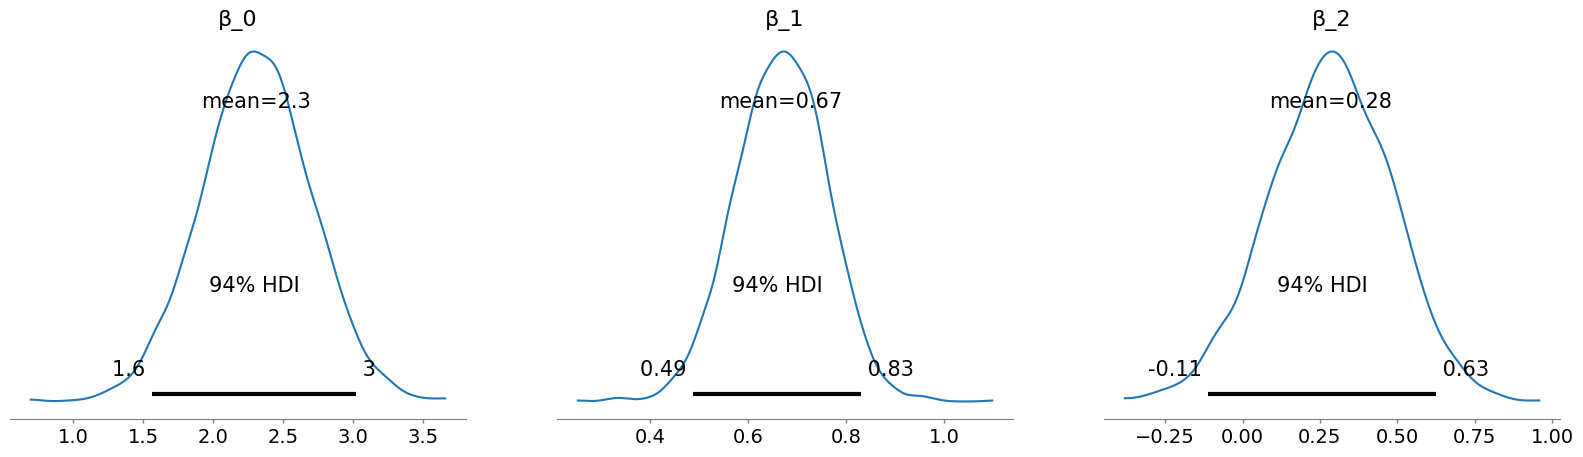

In [154]:
az.plot_posterior(idata_sepal_width_petal_length_regression, var_names =["β_0", "β_1", "β_2"], figsize=(20, 5));

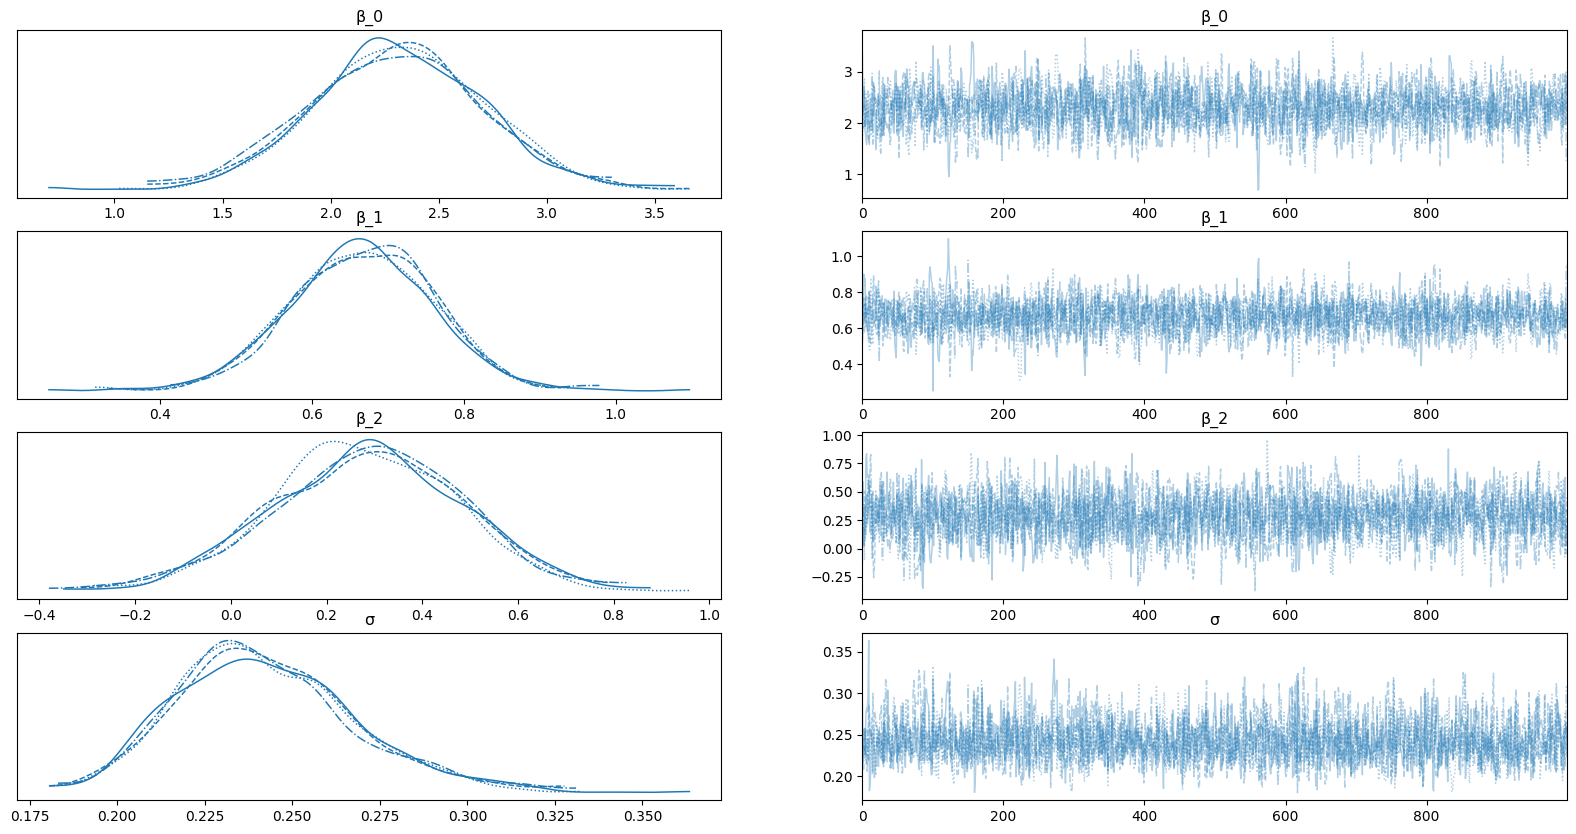

In [155]:
axes = az.plot_trace(idata_sepal_width_petal_length_regression,var_names=["β_0","β_1",'β_2', "σ"], figsize=(20, 10))

In [156]:
az.summary(idata_sepal_width_petal_length_regression, var_names=["β_0","β_1","β_2", "σ"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β_0,2.307,0.392,1.566,3.022,0.009,0.006,1932.0,2118.0,1.0
β_1,0.667,0.093,0.489,0.830,0.002,0.001,2203.0,2088.0,1.0
β_2,0.283,0.197,-0.110,0.626,0.004,0.003,2005.0,1656.0,1.0
σ,0.242,0.025,0.197,0.291,0.001,0.000,2353.0,2127.0,1.0


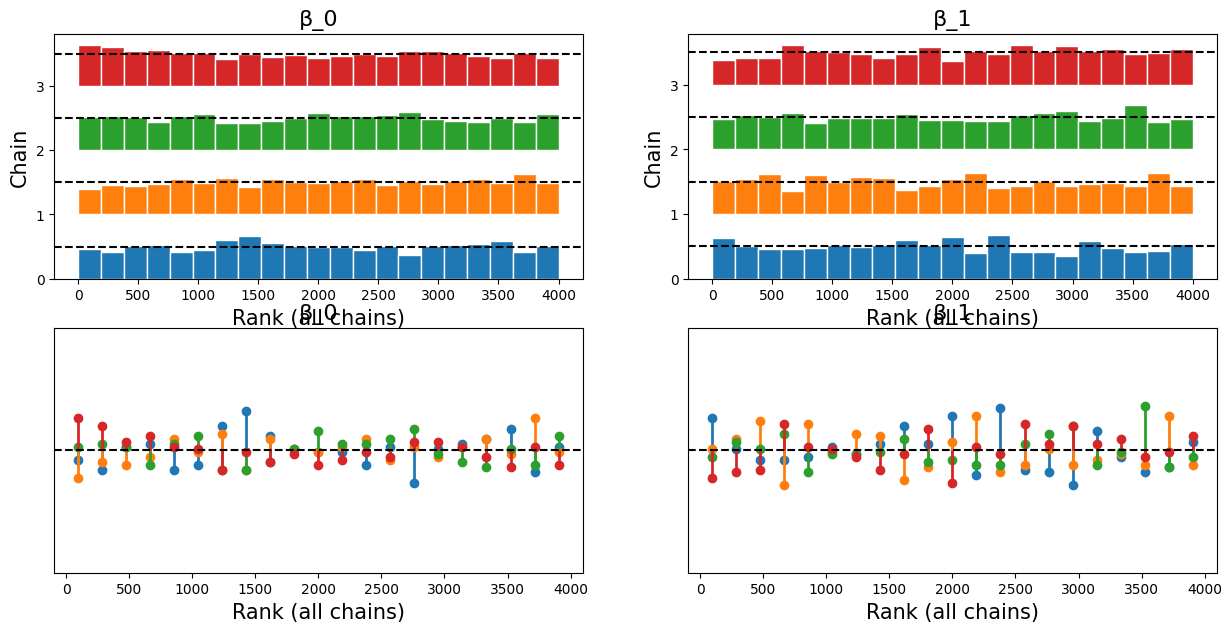

In [159]:
fig, (ax1,ax2) = plt.subplots(2,2, figsize=(15,7))
az.plot_rank(idata_sepal_width_petal_length_regression, kind="bars", ax=ax1);
az.plot_rank(idata_sepal_width_petal_length_regression, kind="vlines", ax=ax2);

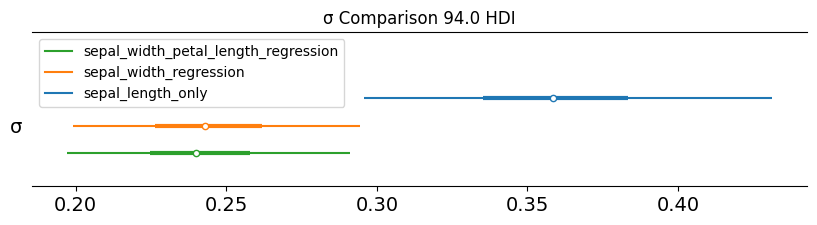

In [157]:
axes = az.plot_forest(
    [idata_sepal_length, idata_sepal_width_regression, idata_sepal_width_petal_length_regression],
    model_names=["sepal_length_only", "sepal_width_regression","sepal_width_petal_length_regression"],
    var_names=["σ"], combined=True, figsize=(10, 2))

axes[0].set_title("σ Comparison 94.0 HDI");

## линейная регрессия с шириной чашелистника, длиной лепестка, шириной лепестка

In [158]:
setosa_petal_width_obs=iris_dataset.loc[setosa_mask, "petal width (cm)"]

with pm.Model() as model_sepal_width_petal_length_width_regression:
    σ = pm.HalfNormal("σ", 10)
    β_0 = pm.Normal("β_0", 0, 10)
    β_1 = pm.Normal("β_1", 0, 10)
    β_2 = pm.Normal("β_2", 0, 10)
    β_3 = pm.Normal("β_3", 0, 10)
    μ = pm.Deterministic("μ", β_0 + β_1 * setosa_sepal_width_obs+ β_2 * setosa_petal_length_obs+β_3*setosa_petal_width_obs)

    sepal_length = pm.Normal("sepal length", mu=μ, sigma=σ, observed=setosa_sepal_length_obs)

    idata_sepal_width_petal_width_length_regression = pm.sample(chains=4)

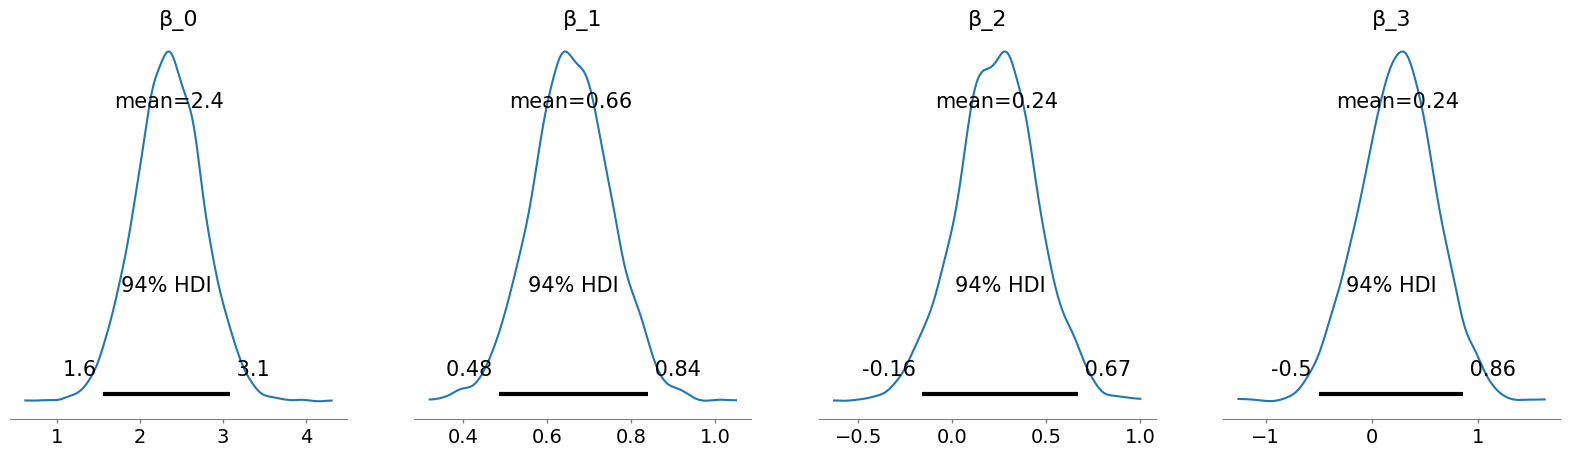

In [160]:
az.plot_posterior(idata_sepal_width_petal_width_length_regression, var_names =["β_0", "β_1", "β_2","β_3"], figsize=(20, 5));

In [161]:
np.mean(idata_sepal_width_petal_length_regression.posterior[["β_0", "β_1", "β_2"]]>1e-2)

<xarray.Dataset> Size: 24B
Dimensions:  ()
Data variables:
    β_0      float64 8B 1.0
    β_1      float64 8B 1.0
    β_2      float64 8B 0.9163

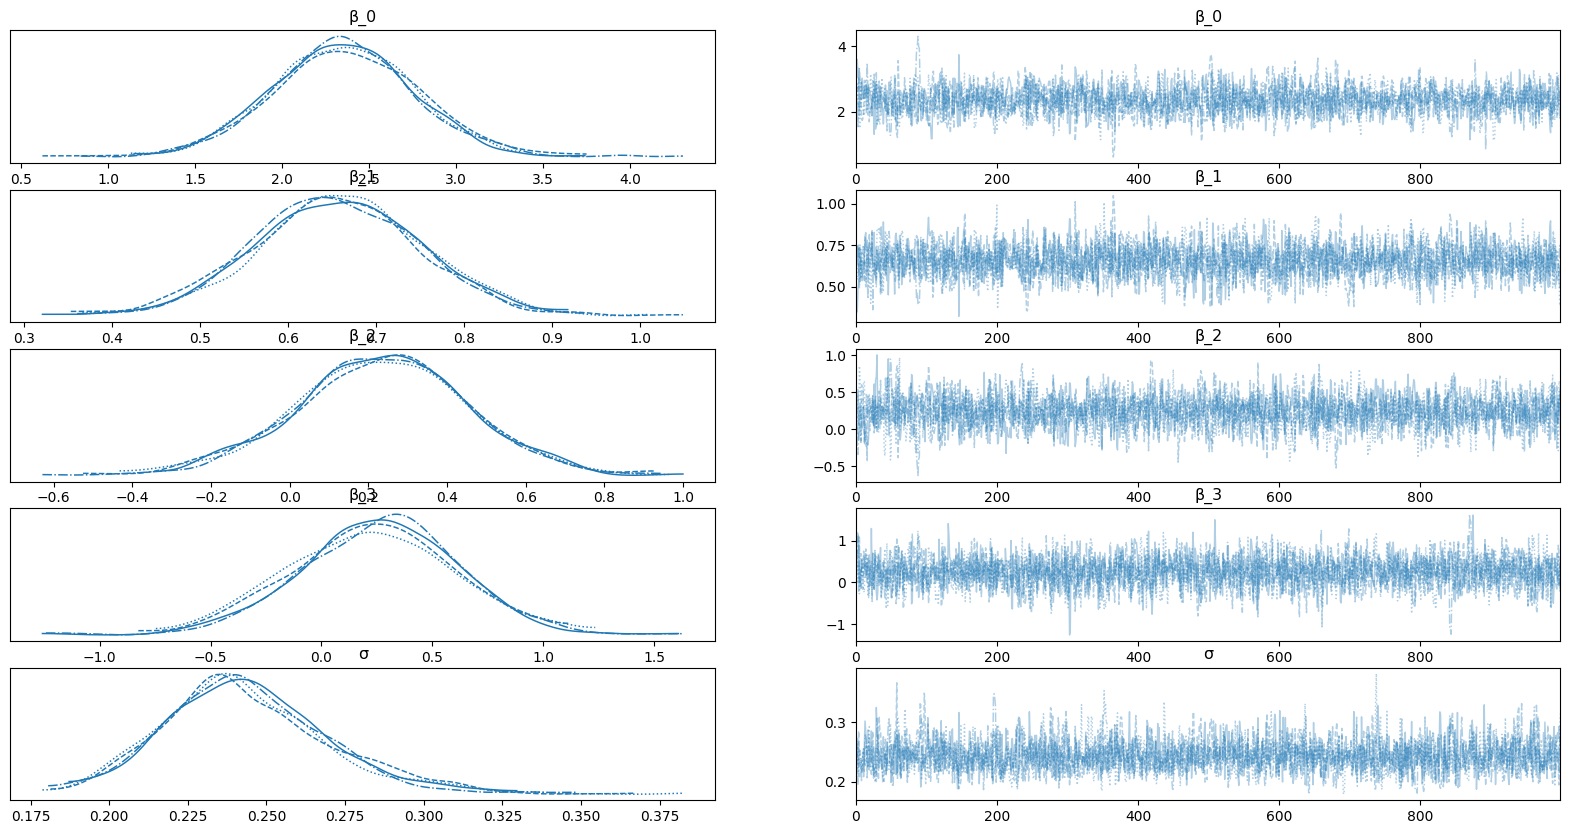

In [162]:
axes = az.plot_trace(idata_sepal_width_petal_width_length_regression,var_names=["β_0","β_1",'β_2', "β_3","σ"], figsize=(20, 10))

In [163]:
az.summary(idata_sepal_width_petal_width_length_regression, var_names=["β_0","β_1",'β_2', "β_3","σ"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β_0,2.351,0.410,1.558,3.084,0.010,0.007,1822.0,2150.0,1.0
β_1,0.657,0.095,0.485,0.839,0.002,0.001,2319.0,2224.0,1.0
β_2,0.235,0.217,-0.159,0.666,0.005,0.003,2114.0,1794.0,1.0
β_3,0.245,0.362,-0.500,0.861,0.007,0.005,2711.0,1978.0,1.0
σ,0.244,0.026,0.196,0.294,0.001,0.000,2549.0,2060.0,1.0


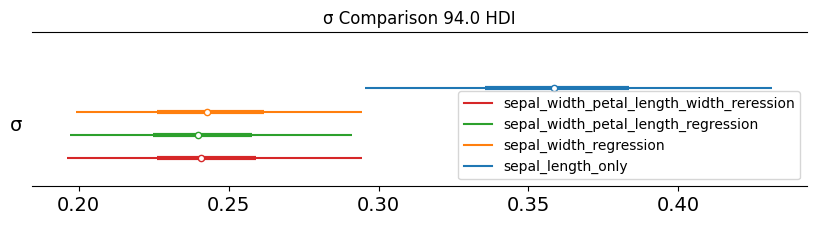

In [164]:
axes = az.plot_forest(
    [idata_sepal_length, idata_sepal_width_regression, idata_sepal_width_petal_length_regression,idata_sepal_width_petal_width_length_regression],
    model_names=["sepal_length_only", "sepal_width_regression","sepal_width_petal_length_regression",'sepal_width_petal_length_width_reression'],
    var_names=["σ"], combined=True, figsize=(10, 2))

axes[0].set_title("σ Comparison 94.0 HDI");

In [42]:
ppc2 = pm.sample_posterior_predictive(idata_sepal_width_petal_width_length_regression, model=model_sepal_width_petal_length_width_regression)
az.r2_score(setosa_sepal_length_obs, ppc2.posterior_predictive['sepal length'].mean(axis=0).values)

,0
r2,0.558795
r2_std,0.048470


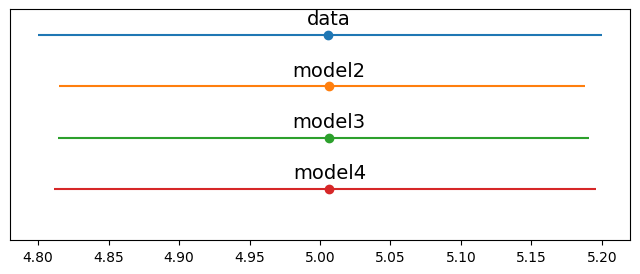

In [165]:
plt.figure(figsize=(8, 3))
y_1s = setosa_sepal_length_obs
y_model4 = pm.sample_posterior_predictive(idata_sepal_width_petal_width_length_regression, model=model_sepal_width_petal_length_width_regression).posterior_predictive['sepal length'].mean(axis=0)
y_model3=pm.sample_posterior_predictive(idata_sepal_width_petal_length_regression, model=model_sepal_width_petal_length_regression).posterior_predictive['sepal length'].mean(axis=0)
y_model2=pm.sample_posterior_predictive(idata_sepal_width_regression, model=model_sepal_width_regression).posterior_predictive['sepal length'].mean(axis=0)

data = [y_1s, y_model2,y_model3,y_model4]
labels = ['data', 'model2','model3','model4']

for i, d in enumerate(data):
    mean = d.mean()
    err = np.percentile(d, [25, 75])
    plt.errorbar(mean, -i, xerr=[[mean - err[0]], [err[1] - mean]], fmt='o')
    plt.text(mean, -i + 0.2, labels[i], ha='center', fontsize=14)

plt.ylim([-len(data), 0.5])
plt.yticks([])
plt.show()

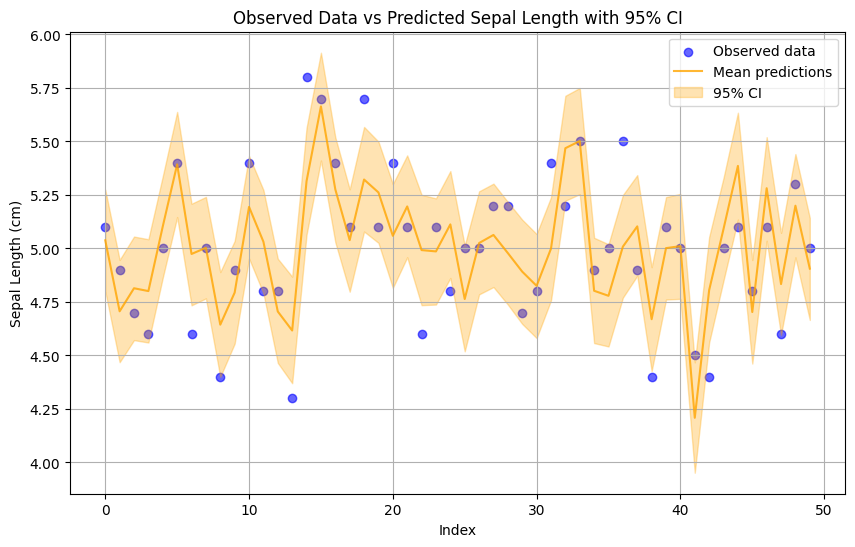

In [166]:
ppc3=pm.sample_posterior_predictive(idata_sepal_width_petal_length_regression, model=model_sepal_width_petal_length_regression).posterior_predictive['sepal length']
predicted_mean = ppc3.mean(axis=0)
predicted_mean_avg = predicted_mean.mean(axis=0)
predicted_hdi_lower = np.percentile(ppc3, 2.5, axis=0).mean(axis=0)
predicted_hdi_upper = np.percentile(ppc3, 97.5, axis=0).mean(axis=0)


plt.figure(figsize=(10, 6))

plt.scatter(np.arange(len(setosa_sepal_length_obs)), setosa_sepal_length_obs, color='blue', label='Observed data', alpha=0.6)

plt.plot(np.arange(len(predicted_mean_avg)), predicted_mean_avg, color='orange', label='Mean predictions', alpha=0.8)


plt.fill_between(np.arange(len(predicted_mean_avg)), predicted_hdi_lower, predicted_hdi_upper, color='orange', alpha=0.3, label='95% CI')


plt.xlabel('Index')
plt.ylabel('Sepal Length (cm)')
plt.title('Observed Data vs Predicted Sepal Length with 95% CI')
plt.legend()
plt.grid(True)
plt.show()

In [169]:
# setosa_sepal_width_centered = setosa_sepal_width_obs - setosa_sepal_width_obs.mean()
# setosa_petal_length_centered = setosa_petal_length_obs - setosa_petal_length_obs.mean()
# setosa_petal_width_centered = setosa_petal_width_obs - setosa_petal_width_obs.mean()

with pm.Model() as model:
    petal_length = pm.MutableData("petal_length",
                                     setosa_petal_length_obs)
    sepal_width=pm.MutableData("sepal_width",
                                     setosa_sepal_width_obs)
    #petal_width=pm.MutableData("petal_width",
                                 #    setosa_petal_width_obs)
    σ = pm.HalfNormal("σ", 10)
    β_0 = pm.Normal("β_0", 0, 10)
    β_1 = pm.Normal("β_1", 0, 10)
    β_2 = pm.Normal("β_2", 0, 10)
    #β_3 = pm.Normal("β_3", 0, 10)
    μ = pm.Deterministic("μ", β_0 + β_1 * sepal_width+β_2*petal_length)

    sepal_length = pm.Normal("sepal length", mu=μ, sigma=σ, observed=setosa_sepal_length_obs)

    idata = pm.sample(chains=4)

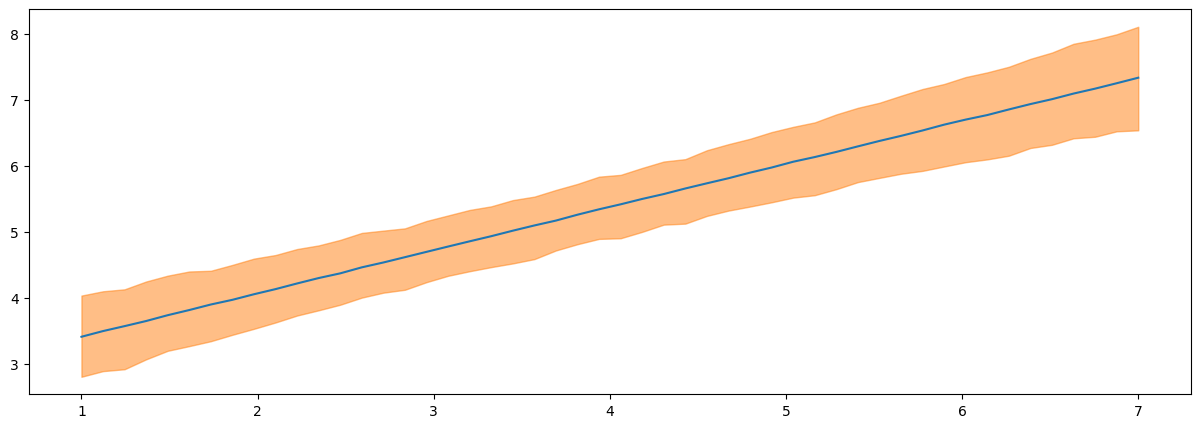

In [168]:
counterfactual_sepal_width = np.linspace(1,7,50)
with model:
    pm.set_data(
        {
            "sepal_width": counterfactual_sepal_width,
            "petal_length": np.ones_like(counterfactual_sepal_width)*
                (setosa_petal_length_obs.mean()),
            #"petal_width": np.ones_like(counterfactual_sepal_width)*
              #  (setosa_petal_width_obs.mean())
        }
    )
    counterfactual = pm.sample_posterior_predictive(
        idata,
        predictions=True,
        var_names=["sepal length", "μ"]
    )

_, ax = plt.subplots(figsize=(15, 5))
az.plot_hdi(counterfactual_sepal_width, counterfactual.predictions["sepal length"],
            hdi_prob=0.94, smooth=False, ax=ax)
ax.plot(counterfactual_sepal_width,
        counterfactual.predictions["sepal length"].mean(("chain", "draw")));